In [8]:
# Limpieza de datos

import pandas as pd

df = pd.read_csv('../data/raw/datos_mexico.csv')

df=df.drop(['_id','RENGLON','ENTIDAD'],axis=1)

# Combinacion de columnas

df['Poblacion de jovenes (3-14)']=df['POB_3_5']+df['POB_6_011']+df['POB_012_014']
df=df.drop(['POB_3_5','POB_6_011','POB_012_014'],axis=1)
df['Poblacion de adultos (15-64)']=df['POB_015_29']+df['POB_30_64']
df = df.drop(['POB_015_017','POB_015_019','POB_015_29','POB_015_49','POB_018_24','POB_20_24','POB_30_64'],axis=1)
df = df.rename(columns={'POB_65_MAS':'Poblacion adultos mayores (65+)'})

# Calculo de tasas de cambio por año

df['Cambio jovenes']=df['Poblacion de jovenes (3-14)'].diff().fillna(0)
df['Cambio adultos']=df['Poblacion de adultos (15-64)'].diff().fillna(0)
df['Cambio mayores']=df['Poblacion adultos mayores (65+)'].diff().fillna(0)

print(df)

    ANIO  Poblacion adultos mayores (65+)  Poblacion de jovenes (3-14)  \
0   2002                          5399307                     27773497   
1   2003                          5576695                     27829732   
2   2004                          5761262                     27861649   
3   2005                          5953231                     27858970   
4   2006                          6155725                     27830965   
5   2007                          6368873                     27795480   
6   2008                          6585485                     27758562   
7   2009                          6808607                     27724088   
8   2010                          7046284                     27705408   
9   2011                          7302545                     27706657   
10  2012                          7569447                     27709468   
11  2013                          7840039                     27692281   
12  2014                          8110

In [ ]:
#df.to_csv('../data/mexico.csv')

In [ ]:
# Modelacion estadistica
import statsmodels.api as sm

# Asegura float en columnas usadas
cols = [
    "Poblacion de adultos (15-64)",
    "Poblacion de jovenes (3-14)",
    "Poblacion adultos mayores (65+)",
    "Cambio jovenes",
    "Cambio adultos",
    "Cambio mayores",
]
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=cols)

x_J = df[["Poblacion de adultos (15-64)", "Poblacion de jovenes (3-14)"]]
y_J = df["Cambio jovenes"]
# x_J = sm.add_constant(x_J,prepend=False)
modelo_J = sm.OLS(
    y_J,
    x_J,
).fit()
coef_J = modelo_J.params.to_dict()

x_A = df[["Poblacion de jovenes (3-14)", "Poblacion de adultos (15-64)"]]
y_A = df["Cambio adultos"]
# x_A = sm.add_constant(x_A,prepend=False)
modelo_A = sm.OLS(
    y_A,
    x_A,
).fit()
coef_A = modelo_A.params.to_dict()

# Incluye A y E para el modelo de mayores (consistente con dyE = alpha*A - c4*E)
x_E = df[["Poblacion de adultos (15-64)", "Poblacion adultos mayores (65+)"]]
y_E = df["Cambio mayores"]
# x_E = sm.add_constant(x_E,prepend=False)
modelo_E = sm.OLS(
    y_E,
    x_E,
).fit()
coef_E = modelo_E.params.to_dict()

print(modelo_J.summary())
print(modelo_A.summary())
print(modelo_E.summary())

                                 OLS Regression Results                                
Dep. Variable:         Cambio jovenes   R-squared (uncentered):                   0.824
Model:                            OLS   Adj. R-squared (uncentered):              0.804
Method:                 Least Squares   F-statistic:                              42.08
Date:                Fri, 14 Nov 2025   Prob (F-statistic):                    1.64e-07
Time:                        11:16:16   Log-Likelihood:                         -244.04
No. Observations:                  20   AIC:                                      492.1
Df Residuals:                      18   BIC:                                      494.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

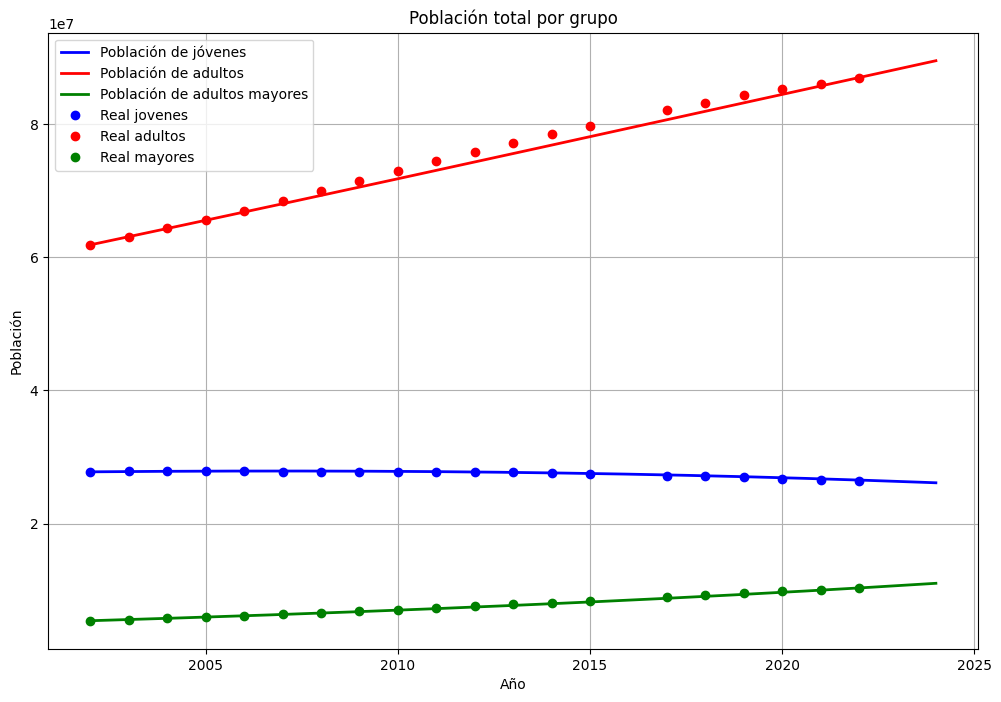

In [4]:
# Graficacion

import numpy as np
import matplotlib.pyplot as plt

def sistema_edos(t, y):
    # y = [J, A, E]
    jt, at, et = y

    # COEFICIENTES
    c1 = -0.0085  # tasa de natalidad
    c2 = -0.0207  # tasa de mortalidad jóvenes
    #const1= -2.161e+06
    tj=0.0359
    c3 = -0.0036  # tasa de mortalidad adultos (positiva)
    #const2=-3.146e+07
    ta=-0.0002
    c4 =  -0.0344 # tasa de mortalidad mayores
    #const3=-1.404e+06

    # ECUACIONES
    dyJ = c1*at-c2*jt#+const1
    dyA = tj*jt-c3*at#+const2
    dyE = ta*at-c4*et#+const3
    return [dyJ, dyA, dyE]

def RK4(func, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    n = len(t_values)
    y_values = np.zeros((n, len(y0)), dtype=float)
    y_values[0] = y0

    for i in range(1, n):
        k1 = np.array(func(t_values[i-1], y_values[i-1]))
        k2 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k1/2))
        k3 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k2/2))
        k4 = np.array(func(t_values[i-1] + h,   y_values[i-1] + h*k3))
        y_values[i] = y_values[i-1] + h*(k1 + 2*k2 + 2*k3 + k4)/6

    return t_values, y_values

# y0 = [J, A, E] en 2002
y0 = [27773497,61886631,5399307]
t0, tf, h = 0, 22, 0.01

t, y = RK4(sistema_edos, y0, t0, tf, h)

years = 2002 + t
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Modelo
ax.plot(years, y[:, 0], 'b-', linewidth=2, label='Población de jóvenes')
ax.plot(years, y[:, 1], 'r-', linewidth=2, label='Población de adultos')
ax.plot(years, y[:, 2], 'g-', linewidth=2, label='Población de adultos mayores')
# Reales
years_real=df["ANIO"]
ax.plot(years_real,df["Poblacion de jovenes (3-14)"],'bo',markersize=6,label="Real jovenes")
ax.plot(years_real,df["Poblacion de adultos (15-64)"],'ro',markersize=6,label="Real adultos")
ax.plot(years_real,df["Poblacion adultos mayores (65+)"],'go',markersize=6,label="Real mayores")

ax.set_title('Población total por grupo')
ax.set_xlabel('Año')
ax.set_ylabel('Población')
ax.grid(True)
ax.legend()
plt.show()